# Tarea 3

Usamos un dataset pequeñito de analisis de sentimiento en tweets. Cada tweet viene con una etiqueta entre `positive`, `negative` y `neutral`.

**Vamos a ver como usar:**
* Utilizar una representacion de word embedding ya entrenada
* Utilizar estes representaciones con MLP y un RNN
* Comparar con un RNN que va apprende su capa de embeddings
* Utilizar un modelo pre-entrenado contextual como BERT

## Se puede utilizar LLM para ayudarse!
Mirar a [un ejemplo](https://chatgpt.com/share/d534833e-bd2c-40c1-81eb-34818b195cac) de como pedir las respuestas a un LLM. Mejor si entenden lo que hagan.

#### Para cada entrenamiento
* Informa de las curvas de pérdida y precisión en el entrenamiento y la validación.
* Detén el entrenamiento en función de los resultados obtenidos en el conjunto de validación.
* Utiliza una tasa de aprendizaje pequeña para que puedas ver cómo disminuye la pérdida en las distintas curvas.  

### Before Starting! Some tips on GPU and Google Colab

You will likely to run this code on Google Colab in order to use GPU ressources. If not, the code will take 60 times more to run!!  

#### Stop disconnection

Colab will disconnect you if you the training is too long. In order to prevent this, you can use this piece of code in the console of your browser:

```java
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
```

See more [here](https://www.reddit.com/r/StableDiffusion/comments/xhhlp0/automatic1111_on_colab_how_to_keep_it_running/).

#### Other account

If you run out of available ressources, what you can do is changing of the account you are using in colab. You can create another gmail and switch to it, this should give you more GPU ressources.

Have fun!

In [1]:
! wget https://users.dcc.uchile.cl/~vbarrier/MModal_Sentiment/Texts.zip
! unzip Texts.zip

--2024-10-22 00:14:23--  https://users.dcc.uchile.cl/~vbarrier/MModal_Sentiment/Texts.zip
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143512 (140K) [application/zip]
Saving to: ‘Texts.zip’

Texts.zip           100%[===================>] 140.15K   306KB/s    in 0.5s    

2024-10-22 00:14:24 (306 KB/s) - ‘Texts.zip’ saved [143512/143512]

Archive:  Texts.zip
  inflating: MModal_Sentiment_dev.tsv  
  inflating: MModal_Sentiment_test.tsv  
  inflating: MModal_Sentiment_train.tsv  


In [2]:
import pandas as pd

def read_data(fn):
    df = pd.read_csv(fn, sep='\t')[['tweet', 'label']]
    X = df.tweet
    y = df.label
    return X, y

split='train'
X_train, y_train = read_data('MModal_Sentiment_%s.tsv'%split)
split='dev'
X_dev, y_dev = read_data('MModal_Sentiment_%s.tsv'%split)
split='test'
X_test, y_test = read_data('MModal_Sentiment_%s.tsv'%split)

## Word2vec

Construir una funcion que va a representar un texto. Utilizamos `'glove-twitter-25'` porque es el mas pequeño. Pueden probar con otros modelos mas grandes!

In [3]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [4]:
wv_string = 'glove-twitter-25'
# wv_string = 'glove-twitter-200'
#wv_string = 'word2vec-google-news-300'
wv = gensim.downloader.load(wv_string)

[==================================================] 100.0% 104.8/104.8MB downloaded


Visualizamos el vector de la palabra *computer*, y cuales son las palabras de los vectores los mas similares en el espacio utilizando la distancia cosinus

In [5]:
wv['computer'], wv.most_similar('computer')

(array([ 0.64005 , -0.019514,  0.70148 , -0.66123 ,  1.1723  , -0.58859 ,
         0.25917 , -0.81541 ,  1.1708  ,  1.1413  , -0.15405 , -0.11369 ,
        -3.8414  , -0.87233 ,  0.47489 ,  1.1541  ,  0.97678 ,  1.1107  ,
        -0.14572 , -0.52013 , -0.52234 , -0.92349 ,  0.34651 ,  0.061939,
        -0.57375 ], dtype=float32),
 [('camera', 0.907833456993103),
  ('cell', 0.891890287399292),
  ('server', 0.874466598033905),
  ('device', 0.8693524599075317),
  ('wifi', 0.863125741481781),
  ('screen', 0.8621907234191895),
  ('app', 0.8615543246269226),
  ('case', 0.8587921857833862),
  ('remote', 0.8583616018295288),
  ('file', 0.8575270771980286)])

### Transform the docs into sequences of embeddings

We take the word-vectors of each of the words in the sentence, so for each sentence we get a sequence of vectors

In [6]:
vocabulary = wv.index_to_key

def from_wd_to_vec(documents):
    documents_wvs = [
        [wv[word] for word in document.lower().split() if word in vocabulary]
        for document in documents
    ]
    return documents_wvs

In [7]:
# TODO: Create the representations
X_train_wvs = from_wd_to_vec(X_train)
X_dev_wvs = from_wd_to_vec(X_dev)
X_test_wvs = from_wd_to_vec(X_test)

#### Visualizacion

Visualiza los vectores en 2D con sus labeles. Usa T-SNE o UMAP

* Para tener un unico vector representando una frase, se puede aggergar los vectores de cada palabra tomando en promedio de los vectores

Por ejemplo utilizando:
```python
documents_wv = [np.mean(list_wv_sent, axis=0) for list_wv_sent in documents_wvs]
```

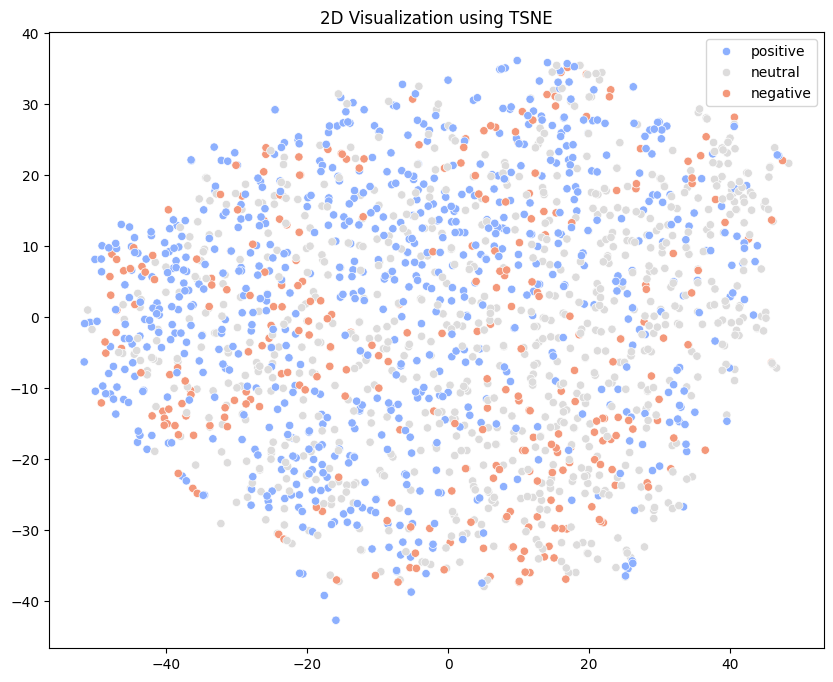

In [8]:
# TODO: Visualization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Convert document sequences of word vectors into single vectors (mean)
def aggregate_vectors(documents_wvs):
    # Aggregate only non-empty documents
    documents_wv = []
    for list_wv_sent in documents_wvs:
        if len(list_wv_sent) > 0:  # Check if there are valid word vectors
            avg_vector = np.mean(list_wv_sent, axis=0)
            documents_wv.append(avg_vector)
    return np.array(documents_wv)

# Apply the aggregation function to your data
X_train_agg = aggregate_vectors(X_train_wvs)

# Adjust labels to match aggregated vectors
# Note: Make sure the original X_train and y_train are pandas Series or DataFrames
y_train_agg = y_train.iloc[:len(X_train_agg)].values  # Adjust labels to match aggregated vectors

# Choose between T-SNE or UMAP for dimensionality reduction
def visualize_vectors(vectors, labels, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)

    vectors_2d = reducer.fit_transform(vectors)

    # Plotting the 2D points with labels
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], hue=labels, palette='coolwarm', legend='full')
    plt.title(f"2D Visualization using {method.upper()}")
    plt.show()

# Visualize the train data (change method to 'umap' for UMAP)
visualize_vectors(X_train_agg, y_train_agg, method='tsne')



## Modelizacion

**Metricas**: Para este tarea de clasificacion pueden utilizar el score F-1 para estimar las performancias de los modelos  

### Multi-Layer Perceptron

El MLP solo toma un vector en entrada, no una secuencia de vectores, por eso tenemos que agregar los vectores de las palabras de una sentencia en uno.  

* Aggreg the word vectors of each doc to get one vector per doc
* Learn a MLP

In [9]:
documents_wv_aggreg = [np.mean(document, axis=1) for document in X_train_wvs]

Epoch [1/50], Train Loss: 1.0086, Train Acc: 0.4793, Dev Loss: 0.9391, Dev Acc: 0.5614
Epoch [2/50], Train Loss: 0.9291, Train Acc: 0.5763, Dev Loss: 0.8759, Dev Acc: 0.5770
Epoch [3/50], Train Loss: 0.8781, Train Acc: 0.5800, Dev Loss: 0.8424, Dev Acc: 0.5894
Epoch [4/50], Train Loss: 0.8486, Train Acc: 0.5932, Dev Loss: 0.8240, Dev Acc: 0.6190
Epoch [5/50], Train Loss: 0.8301, Train Acc: 0.6028, Dev Loss: 0.8090, Dev Acc: 0.6159
Epoch [6/50], Train Loss: 0.8192, Train Acc: 0.6091, Dev Loss: 0.8004, Dev Acc: 0.6267
Epoch [7/50], Train Loss: 0.8097, Train Acc: 0.6176, Dev Loss: 0.7972, Dev Acc: 0.6314
Epoch [8/50], Train Loss: 0.8067, Train Acc: 0.6123, Dev Loss: 0.7887, Dev Acc: 0.6345
Epoch [9/50], Train Loss: 0.8001, Train Acc: 0.6192, Dev Loss: 0.7894, Dev Acc: 0.6252
Epoch [10/50], Train Loss: 0.7961, Train Acc: 0.6282, Dev Loss: 0.7966, Dev Acc: 0.6267
Epoch [11/50], Train Loss: 0.7941, Train Acc: 0.6335, Dev Loss: 0.7958, Dev Acc: 0.6299
Epoch [12/50], Train Loss: 0.7934, Train 

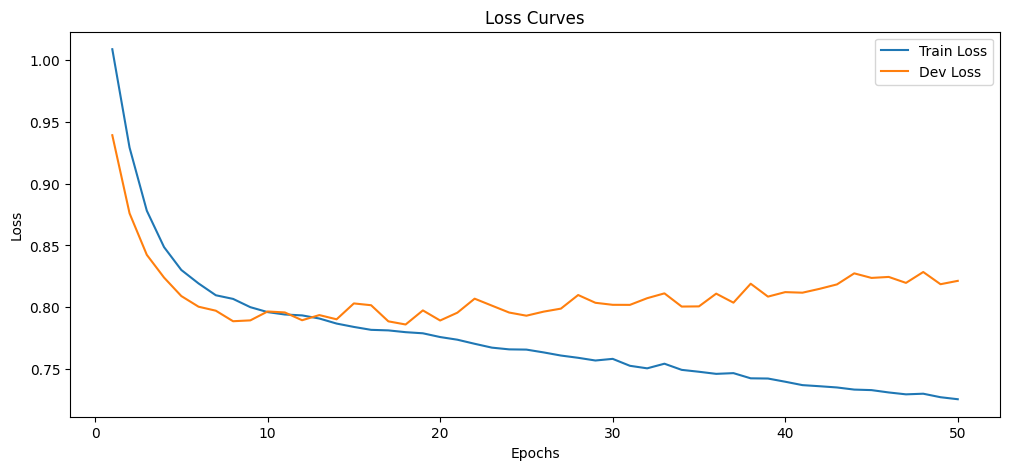

In [16]:
# TODO: MLP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


def aggregate_word_vectors(documents_wvs):
    return np.array([
        np.mean(doc, axis=0) if len(doc) > 0 else np.zeros(wv.vector_size)
        for doc in documents_wvs
    ])


X_train_agg = aggregate_word_vectors(X_train_wvs)
X_dev_agg = aggregate_word_vectors(X_dev_wvs)
X_test_agg = aggregate_word_vectors(X_test_wvs)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)

X_train_tensor = torch.FloatTensor(X_train_agg)
y_train_tensor = torch.LongTensor(y_train_encoded)
X_dev_tensor = torch.FloatTensor(X_dev_agg)
y_dev_tensor = torch.LongTensor(y_dev_encoded)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

input_size = X_train_agg.shape[1]
hidden_size = 100
output_size = len(set(y_train_encoded))
model = MLP(input_size, hidden_size, output_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 50
train_loss_history = []
dev_loss_history = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        total_train_correct += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_correct.double() / len(train_loader.dataset)

    model.eval()
    total_dev_loss = 0
    total_dev_correct = 0

    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_dev_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            total_dev_correct += torch.sum(preds == labels)

    avg_dev_loss = total_dev_loss / len(dev_loader)
    avg_dev_accuracy = total_dev_correct.double() / len(dev_loader.dataset)

    train_loss_history.append(avg_train_loss)
    dev_loss_history.append(avg_dev_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, '
          f'Train Acc: {avg_train_accuracy:.4f}, Dev Loss: {avg_dev_loss:.4f}, Dev Acc: {avg_dev_accuracy:.4f}')




model.eval()
with torch.no_grad():
    X_dev_tensor = X_dev_tensor.to(device)
    y_dev_pred = model(X_dev_tensor)
    y_dev_pred_classes = torch.argmax(y_dev_pred, axis=1).cpu().numpy()

f1 = f1_score(y_dev_encoded, y_dev_pred_classes, average='weighted')
precision = precision_score(y_dev_encoded, y_dev_pred_classes, average='weighted')
recall = recall_score(y_dev_encoded, y_dev_pred_classes, average='weighted')
print(f"F1 Score (Validation Set): {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

X_test_tensor = torch.FloatTensor(X_test_agg)
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_pred = model(X_test_tensor)
    y_test_pred_classes = torch.argmax(y_test_pred, axis=1).cpu().numpy()

f1_test = f1_score(label_encoder.transform(y_test), y_test_pred_classes, average='weighted')
precision_test = precision_score(label_encoder.transform(y_test), y_test_pred_classes, average='weighted')
recall_test = recall_score(label_encoder.transform(y_test), y_test_pred_classes, average='weighted')
print(f"F1 Score (Train Set): {f1_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}")


plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs+1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs+1), dev_loss_history, label='Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

### RNN-LSTM

Use the sequences of wordvectors using a Recurrent Neural Network

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/50], Train Loss: 1.0390, Train Acc: 0.4518, Dev Loss: 0.9827, Dev Acc: 0.4883
Epoch [2/50], Train Loss: 1.0155, Train Acc: 0.4539, Dev Loss: 0.9895, Dev Acc: 0.4883
Epoch [3/50], Train Loss: 1.0103, Train Acc: 0.4539, Dev Loss: 0.9657, Dev Acc: 0.4883
Epoch [4/50], Train Loss: 0.9917, Train Acc: 0.4476, Dev Loss: 0.9735, Dev Acc: 0.4510
Epoch [5/50], Train Loss: 0.9617, Train Acc: 0.4460, Dev Loss: 0.9230, Dev Acc: 0.4806
Epoch [6/50], Train Loss: 0.9525, Train Acc: 0.4608, Dev Loss: 0.9249, Dev Acc: 0.4666
Epoch [7/50], Train Loss: 0.9422, Train Acc: 0.4767, Dev Loss: 0.9413, Dev Acc: 0.4386
Epoch [8/50], Train Loss: 0.9337, Train Acc: 0.4656, Dev Loss: 0.8922, Dev Acc: 0.5054
Epoch [9/50], Train Loss: 0.9242, Train Acc: 0.5058, Dev Loss: 0.9263, Dev Acc: 0.5630
Epoch [10/50], Train Loss: 0.9226, Train Acc: 0.5180, Dev Loss: 0.8802, Dev Acc: 0.5832
Epoch [11/50], Train Loss: 0.9142, Train Acc: 0.5159, Dev Loss: 0.8722, Dev Acc: 0.5583
Epoch [12/50], Train Loss: 0.9053, Train 

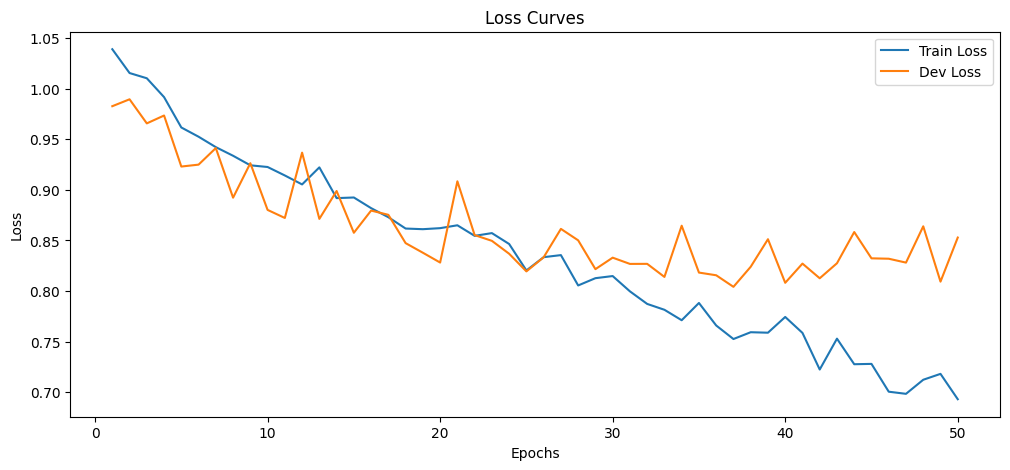

In [15]:
# TODO: RNN-LSTM
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out


def prepare_sequences(documents_wvs, seq_length, vector_size):
    sequences = []
    for doc in documents_wvs:
        if len(doc) > 0:
            if len(doc) >= seq_length:
                sequences.append(doc[:seq_length])
            else:
                padding = np.zeros((seq_length - len(doc), vector_size))
                sequences.append(np.vstack((doc, padding)))
        else:
            sequences.append(np.zeros((seq_length, vector_size)))
    return np.array(sequences)


seq_length = 50
vector_size = wv.vector_size

X_train_seq = prepare_sequences(X_train_wvs, seq_length, vector_size)
X_dev_seq = prepare_sequences(X_dev_wvs, seq_length, vector_size)
X_test_seq = prepare_sequences(X_test_wvs, seq_length, vector_size)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)

X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.LongTensor(y_train_encoded)
X_dev_tensor = torch.FloatTensor(X_dev_seq)
y_dev_tensor = torch.LongTensor(y_dev_encoded)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

input_size = wv.vector_size
hidden_size = 100
output_size = len(set(y_train_encoded))
model = LSTMModel(input_size, hidden_size, output_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 50
train_loss_history = []
dev_loss_history = []
train_accuracy_history = []
dev_accuracy_history = []
epochs = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        total_train_correct += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_correct.double() / len(train_loader.dataset)

    model.eval()
    total_dev_loss = 0
    total_dev_correct = 0

    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_dev_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            total_dev_correct += torch.sum(preds == labels)

    avg_dev_loss = total_dev_loss / len(dev_loader)
    avg_dev_accuracy = total_dev_correct.double() / len(dev_loader.dataset)

    train_loss_history.append(avg_train_loss)
    dev_loss_history.append(avg_dev_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, '
          f'Train Acc: {avg_train_accuracy:.4f}, Dev Loss: {avg_dev_loss:.4f}, Dev Acc: {avg_dev_accuracy:.4f}')



model.eval()
with torch.no_grad():
    X_dev_tensor = X_dev_tensor.to(device)
    y_dev_pred = model(X_dev_tensor)
    y_dev_pred_classes = torch.argmax(y_dev_pred, axis=1).cpu().numpy()

f1 = f1_score(y_dev_encoded, y_dev_pred_classes, average='weighted')
precision = precision_score(y_dev_encoded, y_dev_pred_classes, average='weighted')
recall = recall_score(y_dev_encoded, y_dev_pred_classes, average='weighted')
print(f"F1 Score (Validation Set): {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

X_test_tensor = torch.FloatTensor(X_test_seq).to(device)
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    y_test_pred_classes = torch.argmax(y_test_pred, axis=1).cpu().numpy()

f1_test = f1_score(label_encoder.transform(y_test), y_test_pred_classes, average='weighted')
precision_test = precision_score(label_encoder.transform(y_test), y_test_pred_classes, average='weighted')
recall_test = recall_score(label_encoder.transform(y_test), y_test_pred_classes, average='weighted')
print(F"F1 Score (Train Set): {f1_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}")


plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs+1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs+1), dev_loss_history, label='Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

### Preguntas

* Cuál es la ventaja de la modelización con RNN sobre MLP al usar una agregación de word embeddings?
* Cuál es el beneficio de inicializar el RNN con los word embeddings de Word2Vec?
* Como se comparan los entrenamientos de los diferentes modelos?
* Como se comparan los resultados de los diferentes modelos?
* Que podemos ver con modelos de embedding mas grandes (complejos)?

### Respuestas

* La ventaja de usar redes neuronales recurrentes (RNN) sobre las Redes neuronales multicapa (MLP) al usar word embeddings es que las RNN estan disñadas para manejar secuencias de datos lo que la hace mucho mas idonea para este tipo de tareas donde como se ordenan las palabras modifica el significado de la frase.

* Al usar los embeddings de word2Vec para inicializar RNN tenemos la ventaja que partimos de un modelo de embedding robusto asegurando que las representaciones de las palabras capturen susemantica.

* Con respecto al entrenamiento

* Contrario a lo que se esperaba obtener ambos modelos llegan a resultados parecidos y en ambos casos se da que llegado a un punto si bien la perdida en el dataset de entrenamiento se mantiene bajando en el dataset Dev se vuelve constante.

*

## BERT

Use a pre-trained BERT from the HuggingFace library and fine-tune it on the dataset.

* For the data, you can use the classes `Dataset` and `DataLoader` from `torch.utils.data`
* For the modelization:
  * You can use the classes `BertTokenizer` and `BertForSequenceClassification` from the `transformers` library
  * Load the weights of the models already pre-trained, with the associated tokenizer!
  * You can use a [classical bert](https://huggingface.co/bert-base-uncased) `'bert-base-uncased'`  
  * You can also use another model from huggingface, like [a smaller model](https://huggingface.co/distilbert-base-uncased) such as `distilbert-base-uncased` (it is an example)
* For the fine-tuning (optimization):
    * Make the loop in pytorch, **do not use** the class `Trainer` from the `transformers` library
    * You can use classical loss functions like cross-entropy and the optimizer you want, `Adam` or `AdamW` for example.
    * Reports the loss and accuracy curves on the train and validation
    * Stop the training regarding the performances obtained on the validation set
    * Use a small learning rate so you can see the loss going down on the different curves  

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/5], Train Loss: 0.9611, Train Acc: 0.5387, Dev Loss: 0.8214, Dev Acc: 0.6423
Epoch [2/5], Train Loss: 0.7114, Train Acc: 0.7013, Dev Loss: 0.6820, Dev Acc: 0.7201
Epoch [3/5], Train Loss: 0.4621, Train Acc: 0.8242, Dev Loss: 0.7428, Dev Acc: 0.7201
Epoch [4/5], Train Loss: 0.2708, Train Acc: 0.9153, Dev Loss: 0.9122, Dev Acc: 0.7154
Epoch [5/5], Train Loss: 0.1574, Train Acc: 0.9539, Dev Loss: 1.1208, Dev Acc: 0.6734
F1 Score (Validation Set): 0.9793, Precision: 0.9799, Recall: 0.9793
F1 Score (Test Set): 0.6659, Precision: 0.7002, Recall: 0.6734


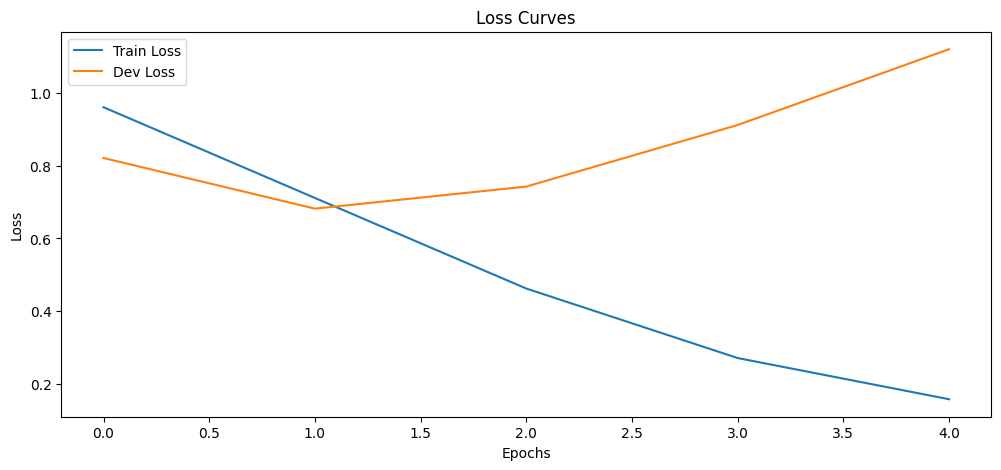

In [22]:
# TODO: BERT
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y_train)))


max_len = 128
train_dataset = TextDataset(X_train.tolist(), y_train_encoded.tolist(), tokenizer, max_len)
dev_dataset = TextDataset(X_dev.tolist(), y_dev_encoded.tolist(), tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


train_loss_history = []
dev_loss_history = []
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_correct = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        _, preds = torch.max(outputs.logits, dim=1)
        total_train_correct += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_correct.double() / len(train_loader.dataset)

    model.eval()
    total_dev_loss = 0
    total_dev_correct = 0

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_dev_loss += loss.item()

            _, preds = torch.max(outputs.logits, dim=1)
            total_dev_correct += torch.sum(preds == labels)

    avg_dev_loss = total_dev_loss / len(dev_loader)
    avg_dev_accuracy = total_dev_correct.double() / len(dev_loader.dataset)

    train_loss_history.append(avg_train_loss)
    dev_loss_history.append(avg_dev_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, '
          f'Dev Loss: {avg_dev_loss:.4f}, Dev Acc: {avg_dev_accuracy:.4f}')


model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for batch  in train_loader:
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=inputs, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
print(f"F1 Score (Validation Set): {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

with torch.no_grad():
  all_preds_test = []
  all_labels_test = []
  for batch in dev_loader:
      inputs = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = model(input_ids=inputs, attention_mask=attention_mask)
      logits = outputs.logits
      _, preds = torch.max(logits, dim=1)
      all_preds_test.extend(preds.cpu().numpy())
      all_labels_test.extend(labels.cpu().numpy())

f1_test = f1_score(all_labels_test, all_preds_test, average='weighted')
precision_test = precision_score(all_labels_test, all_preds_test, average='weighted')
recall_test = recall_score(all_labels_test, all_preds_test, average='weighted')
print(F"F1 Score (Test Set): {f1_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(dev_loss_history, label='Dev Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Preguntas

* Haz una hipótesis sobre por qué los resultados de BERT son mejores que los de otros modelos.
* Cuál es la principal limitación de Word2Vec en comparación con BERT a nivel lingüístico al representar palabras? Propón un ejemplo.
* Visualiza los vectores del token `[CLS]` de BERT después del fine-tuning. Qué diferencias notas en comparación con antes?
* Qué sucede si utilizas un modelo diferente, como RoBERTa?

#### Respuestas

* Una hipotesis de porque BERT ofrece mejores resultados que los otros modelos es que mientras que MLP solo considera una palabra sin contexto y que RNN solo considera el contexto de las palabras que vinieron antes, BERT evalua usando el contexto completo, las palabras que vinieron antes y las que vfienen despues, lo que permite captar mejor la semantica.

*